In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import split, col
import os
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [2]:
sc = SparkContext(master="local[4]")
sqlContext = SQLContext(sc)

In [3]:
def clean_schema(self):
    df_no_na = self.df_orig_1.na.drop()
    df_orig_2 = df_no_na.withColumn(self.utilName+"_MW", df_no_na[self.utilName+'_MW'].cast('double'))
    split_col = split(df_orig_2['Datetime'], '-')
    df_orig_2 = df_orig_2.withColumn('year', split_col.getItem(0))
    df_orig_2 = df_orig_2.withColumn('month', split_col.getItem(1))
    df_orig_2 = df_orig_2.withColumn('daytime', split_col.getItem(2))
    split_last_col = split(df_orig_2['daytime'], ' ')
    df_orig_2 = df_orig_2.withColumn('day', split_last_col.getItem(0))
    df_orig_2 = df_orig_2.withColumn('hour', split_last_col.getItem(1)[0:2])
    df_orig_2 = df_orig_2.drop("Datetime")
    df_orig_2 = df_orig_2.drop("daytime")
    df_orig_3 = df_orig_2.withColumn('year', df_orig_2['year'].cast('int'))
    df_orig_4 = df_orig_3.withColumn('month', df_orig_3['month'].cast('int'))
    df_orig_5 = df_orig_4.withColumn('day', df_orig_4['day'].cast('int'))
    self.df_clean_schema = df_orig_5.withColumn('hour', df_orig_5['hour'].cast('int'))


In [4]:
#def download_file(utilName):
#    filePath = "Elec_Data/"+utilName+"_Hourly.csv"
#    fileLink = r"'https://www.kaggle.com/robikscube/hourly-energy-consumption/download/"+utilName+"_hourly.csv.zip'"
#    fileName = "Elec_Data/"+utilName+"_hourly.csv.zip"
#    ! test -e $filePath && echo "Files necesarry already exist" || wget $fileLink -P Elec_Data
#    ! test -e $filePath && echo "Files already unzipped" || unzip $fileName 

In [5]:
def find_incomplete_yrs(self):
    sqlContext.registerDataFrameAsTable(self.df_clean_schema,'elec_data')
    query="""
    SELECT year ,COUNT(AEP_MW) AS count 
    FROM elec_data 
    GROUP BY year 
    ORDER BY year
    """
    
    sqlContext.sql(query).show()
    
    query2="""
    SELECT year ,COUNT(AEP_MW) AS count 
    FROM elec_data
    GROUP BY year
    HAVING count<7800
    ORDER BY year
    """
    
    df_incomplete_yrs=sqlContext.sql(query2)
    self.rdd_incomplete_yrs=df_incomplete_yrs.rdd.map(lambda row: np.int(row['year']))


    

In [6]:
def remove_incomplete_yrs(self):
    badyrs = self.rdd_incomplete_yrs.collect()
    self.whereQuery = "WHERE ("
    for yrs in badyrs:
        if yrs == badyrs[len(badyrs)-1]:
            self.whereQuery = self.whereQuery+"year!="+str(yrs)+")"
        else:
            self.whereQuery = self.whereQuery+"year!="+str(yrs)+" and "
    sqlContext.registerDataFrameAsTable(self.df_clean_schema,'elec_data')
    query="SELECT * FROM elec_data "+self.whereQuery+" ORDER BY year, month, day, hour"
    self.df_full_yrs=sqlContext.sql(query)
    

In [7]:
def find_incomplete_days(self):
    sqlContext.registerDataFrameAsTable(self.df_full_yrs,'elec_data')
    query="SELECT  month, day , year, count(AEP_MW) as count_meas \
    FROM elec_data \
    GROUP BY month, day, year \
    ORDER BY count_meas ASC"
    df_hourly_count=sqlContext.sql(query)

    df_hourly_pre = self.df_full_yrs.join(df_hourly_count, on=['month', 'day','year'], how='inner')
    df_hourly_pre.show()
    print("number of total days: ", df_hourly_pre.count())
    sqlContext.registerDataFrameAsTable(df_hourly_pre,'elec_data2')
    query2="SELECT  year, month, day , hour, AEP_MW \
    FROM elec_data2 \
    WHERE count_meas==24\
    ORDER BY year, month, day, hour"
    self.df_final=sqlContext.sql(query2)
    self.df_final.show()
    print("number of days with 24 hours: ", self.df_final.count())
    

    
    #sqlContext.registerDataFrameAsTable(df_hourly_pre,'hourly_data_daily_count')
    #df_hourly_pre.count()
    
    



In [8]:
def return_hourly_average(self):
    sqlContext.registerDataFrameAsTable(self.df_final,'elec_data')

    query="""
    SELECT  AVG(AEP_MW) AS avg_MW_per_hr , hour 
    FROM elec_data
    GROUP BY hour
    ORDER BY hour
    """

    df_hourly_avg=sqlContext.sql(query)
    df_hourly_avg.show(24)
    rdd_hourly_avg_pre=df_hourly_avg.rdd.map(lambda row: np.float(row['avg_MW_per_hr']))
    self.hourly_avg=np.array(rdd_hourly_avg_pre.collect())
    return self.hourly_avg

In [9]:
def return_grouped_df(self):
    sqlContext.registerDataFrameAsTable(self.df_final,'elec_data')
    query="""
    SELECT  month, day , year, concat_ws(',', collect_list(AEP_MW)) as day_consump
    FROM elec_data
    GROUP BY month, day, year
    ORDER BY year, month, day

    """

    df_final_grouped_pre=sqlContext.sql(query)
    self.df_final_grouped = df_final_grouped_pre.withColumn("day_consump", split(col("day_consump"), ",").cast("array<long>"))
    return self.df_final_grouped

In [10]:
def return_covariance_matrix(self):
    rdd_daily_outer=self.df_final_grouped.rdd.map(lambda row: np.outer(np.array(row['day_consump']),np.array(row['day_consump'])))
    rdd_outer_sum=rdd_daily_outer.reduce(lambda x, y: x+y)
    #print(rdd_outer_sum.shape)
    expec_of_outer=rdd_outer_sum/self.df_final_grouped.count()
    day_expec_outer_prod=np.outer(self.hourly_avg, self.hourly_avg)
    self.cov_hours=expec_of_outer-day_expec_outer_prod
    return self.cov_hours
    
    
    
    
    

In [11]:
def return_eig_data(self, plotFlag):
    self.eigvals,self.eigvecs = LA.eig(self.cov_hours)
    e_val_percent=([0,]+list(np.cumsum(self.eigvals)))/sum(self.eigvals)
    e_val_percent=([0,]+list(np.cumsum(self.eigvals)))/sum(self.eigvals)
    if plotFlag == True:
        print("Percent of trace by comulative sum of eigenvalues:",e_val_percent)
        plt.plot(list(range(e_val_percent[:4].size)),e_val_percent[:4])
        plt.title('Percentage of Variance Explained (Cov. Trace)')
        plt.ylabel('Percentage of Variance')
        plt.xlabel('# Eigenvectors')
        plt.xticks(list(range(e_val_percent[:4].size)),list(range(e_val_percent[:4].size)))
        plt.show()
        
        plt.figure(figsize=(15,7))
        plt.plot(list(range(self.hourly_avg.size)), self.eigvecs[0], label="1st principal eigvec")
        plt.plot(list(range(self.hourly_avg.size)), self.eigvecs[1], label="2nd principal eigvec")
        plt.plot(list(range(self.hourly_avg.size)), np.zeros(24), label="zero")
        plt.title('Principal eigen vectors')
        plt.ylabel('MW_per_hr')
        plt.xlabel('Hours')
        plt.xticks(list(range(self.hourly_avg.size)),list(range(self.hourly_avg.size)))
        plt.show()
        
        
    return [self.eigvals, self.eigvecs]


In [12]:
def return_stdev_data(self, plotFlag):
    
    sqlContext.registerDataFrameAsTable(self.df_final,'elec_data')
    query="""
    SELECT  hour, STDDEV(AEP_MW) AS STDEV_MW_per_hr 
    FROM elec_data
    GROUP BY hour
    ORDER BY hour
    """

    df_hr_stdev=sqlContext.sql(query)
    df_hr_stdev.show(24)
    rdd_hr_stdev=df_hr_stdev.rdd.map(lambda row: np.float(row['STDEV_MW_per_hr']))
    self.hour_stdev=np.array(rdd_hr_stdev.collect())

    if plotFlag == True:
        plt.figure(figsize=(15,7))
        plt.plot(list(range(self.hour_stdev.size)),self.hourly_avg, label="avg")
        plt.plot(list(range(self.hour_stdev.size)),self.hourly_avg-self.hour_stdev, label="avg-stdev")
        plt.plot(list(range(self.hour_stdev.size)),self.hourly_avg+self.hour_stdev, label="avg+stdev")
        plt.title('Avg MW used per hour')
        plt.ylabel('MW per hour')
        plt.xlabel('Hour')
        plt.xticks(list(range(self.hour_stdev.size)),list(range(self.hourly_avg.size)))
        plt.legend()
        plt.show()
    return self.hour_stdev

In [79]:
def compute_decomposition(grouped_df, hr_avg, eigvecs):
   # self.eigvecs
   # self.hourly_avg
    
    
    rdd_MW_daily = grouped_df.rdd.map(lambda row: ([row['month'],row['day'],row['year']],np.array(row['day_consump'])))
    #rdd_test1=rdd_MW_daily.map(lambda row: (row[0],row[1]-AEP_hr_avg)) 
    rdd_daily_coef=rdd_MW_daily.map(lambda row: (row[0],np.dot(row[1]-hr_avg, eigvecs[:,0:2])))
    rdd_daily_approx=rdd_daily_coef.map(lambda row: (row[0],hr_avg+np.dot(eigvecs[:,0:2],row[1]) ))   
    rdd_daily_res=rdd_MW_daily.map(lambda row: (row[0],LA.norm(hr_avg+ np.dot(eigvecs[:,0:2],np.dot(row[1]-hr_avg, eigvecs[:,0:2]))-row[1])))

    return [rdd_MW_daily, rdd_daily_coef, rdd_daily_approx, rdd_daily_res]
    
    
    
    
    #self.rdd_MW_daily = self.df_final_grouped.rdd.map(lambda row: ([row['month'],row['day'],row['year']],np.array(row['day_consump'])))
    #rdd_test1=rdd_MW_daily.map(lambda row: (row[0],row[1]-AEP_hr_avg)) 
    #self.rdd_daily_coef=self.rdd_MW_daily.map(lambda row: (row[0],np.dot(row[1]-self.hourly_avg, self.eigvecs[:,0:2])))
    #self.rdd_daily_approx=self.rdd_daily_coef.map(lambda row: (row[0],self.hourly_avg+np.dot(self.eigvecs[:,0:2],row[1]) ))   
    #self.rdd_daily_res=self.rdd_MW_daily.map(lambda row: (row[0],LA.norm(self.hourly_avg+ np.dot(self.eigvecs[:,0:2],np.dot(row[1]-self.hourly_avg,self.eigvecs[:,0:2]))-row[1])))
    #rdd_MW_daily=rdd_MW_daily.map(lambda row: (row[0],np.dot(row[2]-AEP_hr_avg, AEP_grouped_df.eigvecs[:,0:2]))) 
    #print(self.rdd_daily_approx.take(5))

In [99]:
def return_min_res_date(self):
    temp_rdd_daily_res =self.rdd_daily_res.map(lambda row: (row[0],float(row[1])))
    res_df_pre = temp_rdd_daily_res.toDF(["date","res"])
    res_df_sort = res_df_pre.sort("res")
    rdd_sort_date = res_df_sort.rdd.map(lambda row: row["date"])
    self.date_min_res = rdd_sort_date.take(1)[0]
    return self.date_min_res

    

In [172]:
def plot_date_decomp(self, date):
    temp_sol = self.rdd_MW_daily.lookup(date)[0]
    temp_approx = self.rdd_daily_approx.lookup(date)[0]
    temp_residual = self.rdd_daily_res.lookup(date)[0]
    plt.figure(figsize=(15,7))
    plt.plot(list(range(self.hourly_avg.size)),self.hourly_avg, label="Mean Sol")
    plt.plot(list(range(self.hourly_avg.size)),temp_approx, label="2 PC sol")
    plt.plot(list(range(self.hourly_avg.size)),temp_sol, label="actual sol")
    tempTitle = "MW used/ approx, Date: "+str(date[0])+"/"+str(date[1])+"/"+str(date[2])+\
    " Residual (MW): "+"%0.3f" % (temp_residual)
    
    #"The value of x is %4d." % (x)
    plt.title(tempTitle)
    plt.ylabel('MW per hour')
    plt.xlabel('Hour')
    plt.xticks(list(range(self.hourly_avg.size)),list(range(self.hourly_avg.size)))
    plt.legend()
    plt.show()
    
    

In [173]:
import types
class Consumption_Dataset:
    def __init__(self, utilityName):
        self.utilName = utilityName;
        #self.zipFileName = utilityName+"_hourly.csv"
        #self.path = "Elec_Data/"+self.fileName
        #self.link = r"'https://www.kaggle.com/robikscube/hourly-energy-consumption/download/"+self.fileName+"'.zip'"
        #self.download_file = types.MethodType( download_file, self )
        #download_file(self.utilName)
        self.df_orig_1 = sqlContext.read.format("csv").option("header", "true").load("Elec_Data/"+self.utilName+"_hourly.csv")
        self.clean_schema = types.MethodType( clean_schema, self )
        self.find_incomplete_yrs = types.MethodType(find_incomplete_yrs, self )
        self.remove_incomplete_yrs = types.MethodType(remove_incomplete_yrs, self )
        self.find_incomplete_days = types.MethodType(find_incomplete_days, self )
        self.return_hourly_average = types.MethodType(return_hourly_average, self )
        self.return_grouped_df = types.MethodType(return_grouped_df, self )
        self.return_covariance_matrix = types.MethodType(return_covariance_matrix, self )
        self.return_eig_data = types.MethodType(return_eig_data, self )
        self.return_stdev_data = types.MethodType(return_stdev_data, self )
        #self.compute_decomposition = types.MethodType(compute_decomposition, self )
        self.return_min_res_date = types.MethodType(return_min_res_date, self )
        self.plot_date_decomp = types.MethodType(plot_date_decomp, self )

In [174]:
AEP_Data = Consumption_Dataset("AEP")
print("Schema for original dataframe formed from data file:")
AEP_Data.df_orig_1.printSchema()
AEP_Data.df_orig_1.show()

Schema for original dataframe formed from data file:
root
 |-- Datetime: string (nullable = true)
 |-- AEP_MW: string (nullable = true)

+-------------------+-------+
|           Datetime| AEP_MW|
+-------------------+-------+
|2004-12-31 01:00:00|13478.0|
|2004-12-31 02:00:00|12865.0|
|2004-12-31 03:00:00|12577.0|
|2004-12-31 04:00:00|12517.0|
|2004-12-31 05:00:00|12670.0|
|2004-12-31 06:00:00|13038.0|
|2004-12-31 07:00:00|13692.0|
|2004-12-31 08:00:00|14297.0|
|2004-12-31 09:00:00|14719.0|
|2004-12-31 10:00:00|14941.0|
|2004-12-31 11:00:00|15184.0|
|2004-12-31 12:00:00|15009.0|
|2004-12-31 13:00:00|14808.0|
|2004-12-31 14:00:00|14522.0|
|2004-12-31 15:00:00|14349.0|
|2004-12-31 16:00:00|14107.0|
|2004-12-31 17:00:00|14410.0|
|2004-12-31 18:00:00|15174.0|
|2004-12-31 19:00:00|15261.0|
|2004-12-31 20:00:00|14774.0|
+-------------------+-------+
only showing top 20 rows



In [175]:
AEP_Data.clean_schema()
AEP_Data.df_clean_schema.printSchema()
AEP_Data.df_clean_schema.show()
AEP_Data.df_clean_schema.count()

root
 |-- AEP_MW: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)

+-------+----+-----+---+----+
| AEP_MW|year|month|day|hour|
+-------+----+-----+---+----+
|13478.0|2004|   12| 31|   1|
|12865.0|2004|   12| 31|   2|
|12577.0|2004|   12| 31|   3|
|12517.0|2004|   12| 31|   4|
|12670.0|2004|   12| 31|   5|
|13038.0|2004|   12| 31|   6|
|13692.0|2004|   12| 31|   7|
|14297.0|2004|   12| 31|   8|
|14719.0|2004|   12| 31|   9|
|14941.0|2004|   12| 31|  10|
|15184.0|2004|   12| 31|  11|
|15009.0|2004|   12| 31|  12|
|14808.0|2004|   12| 31|  13|
|14522.0|2004|   12| 31|  14|
|14349.0|2004|   12| 31|  15|
|14107.0|2004|   12| 31|  16|
|14410.0|2004|   12| 31|  17|
|15174.0|2004|   12| 31|  18|
|15261.0|2004|   12| 31|  19|
|14774.0|2004|   12| 31|  20|
+-------+----+-----+---+----+
only showing top 20 rows



121273

In [176]:
AEP_Data.find_incomplete_yrs()
AEP_Data.rdd_incomplete_yrs.collect()

+----+-----+
|year|count|
+----+-----+
|2004| 2206|
|2005| 8758|
|2006| 8758|
|2007| 8758|
|2008| 8782|
|2009| 8758|
|2010| 8757|
|2011| 8758|
|2012| 8781|
|2013| 8758|
|2014| 8759|
|2015| 8760|
|2016| 8784|
|2017| 8760|
|2018| 5136|
+----+-----+



[2004, 2018]

In [177]:
AEP_Data.remove_incomplete_yrs()
AEP_Data.df_full_yrs.show()
AEP_Data.df_full_yrs.count()

+-------+----+-----+---+----+
| AEP_MW|year|month|day|hour|
+-------+----+-----+---+----+
|12892.0|2005|    1|  1|   0|
|12316.0|2005|    1|  1|   1|
|11890.0|2005|    1|  1|   2|
|11579.0|2005|    1|  1|   3|
|11461.0|2005|    1|  1|   4|
|11472.0|2005|    1|  1|   5|
|11571.0|2005|    1|  1|   6|
|11898.0|2005|    1|  1|   7|
|12209.0|2005|    1|  1|   8|
|12396.0|2005|    1|  1|   9|
|12997.0|2005|    1|  1|  10|
|13455.0|2005|    1|  1|  11|
|13617.0|2005|    1|  1|  12|
|13665.0|2005|    1|  1|  13|
|13446.0|2005|    1|  1|  14|
|13340.0|2005|    1|  1|  15|
|13159.0|2005|    1|  1|  16|
|13449.0|2005|    1|  1|  17|
|14319.0|2005|    1|  1|  18|
|14536.0|2005|    1|  1|  19|
+-------+----+-----+---+----+
only showing top 20 rows



113931

In [178]:
AEP_Data.find_incomplete_days()

+-----+---+----+-------+----+----------+
|month|day|year| AEP_MW|hour|count_meas|
+-----+---+----+-------+----+----------+
|    1|  1|2005|12892.0|   0|        24|
|    1|  1|2005|12316.0|   1|        24|
|    1|  1|2005|11890.0|   2|        24|
|    1|  1|2005|11579.0|   3|        24|
|    1|  1|2005|11461.0|   4|        24|
|    1|  1|2005|11472.0|   5|        24|
|    1|  1|2005|11571.0|   6|        24|
|    1|  1|2005|11898.0|   7|        24|
|    1|  1|2005|12209.0|   8|        24|
|    1|  1|2005|12396.0|   9|        24|
|    1|  1|2005|12997.0|  10|        24|
|    1|  1|2005|13455.0|  11|        24|
|    1|  1|2005|13617.0|  12|        24|
|    1|  1|2005|13665.0|  13|        24|
|    1|  1|2005|13446.0|  14|        24|
|    1|  1|2005|13340.0|  15|        24|
|    1|  1|2005|13159.0|  16|        24|
|    1|  1|2005|13449.0|  17|        24|
|    1|  1|2005|14319.0|  18|        24|
|    1|  1|2005|14536.0|  19|        24|
+-----+---+----+-------+----+----------+
only showing top

In [179]:
AEP_hr_avg = AEP_Data.return_hourly_average()

#rdd_hour_avg = np.concatenate(np.array(rdd_hour_avg_pre).ravel().tolist()

+------------------+----+
|     avg_MW_per_hr|hour|
+------------------+----+
| 14671.88874761602|   0|
| 13904.05785123967|   1|
|13439.855054036872|   2|
|13188.196863742318|   3|
|  13097.7819453274|   4|
|13242.179275270184|   5|
|13806.066539521085|   6|
|14792.432930705658|   7|
|15490.261284170376|   8|
|15836.711591438865|   9|
|16103.594193685103|  10|
|16333.905700360247|  11|
|16432.198770926043|  12|
| 16516.83619410892|  13|
| 16578.50455605001|  14|
|16540.633396906123|  15|
|16493.837253655434|  16|
|16591.548421275693|  17|
|16806.708200890018|  18|
|16906.230557321465|  19|
|16854.240517058697|  20|
| 16797.99385463022|  21|
| 16504.56622165713|  22|
|15662.884085611358|  23|
+------------------+----+



In [180]:
AEP_grouped_df = AEP_Data.return_grouped_df()
AEP_grouped_df.show()

+-----+---+----+--------------------+
|month|day|year|         day_consump|
+-----+---+----+--------------------+
|    1|  1|2005|[12892, 12316, 11...|
|    1|  2|2005|[12849, 12291, 11...|
|    1|  3|2005|[13080, 12566, 12...|
|    1|  4|2005|[14163, 13421, 12...|
|    1|  5|2005|[14781, 13994, 13...|
|    1|  6|2005|[14860, 13813, 13...|
|    1|  7|2005|[15106, 14471, 14...|
|    1|  8|2005|[15086, 14347, 13...|
|    1|  9|2005|[14546, 13862, 13...|
|    1| 10|2005|[14555, 14135, 13...|
|    1| 11|2005|[15298, 14780, 14...|
|    1| 12|2005|[14891, 13967, 13...|
|    1| 13|2005|[13551, 12744, 12...|
|    1| 14|2005|[14661, 13948, 13...|
|    1| 15|2005|[16588, 15879, 15...|
|    1| 16|2005|[15838, 15207, 15...|
|    1| 17|2005|[17716, 17280, 17...|
|    1| 18|2005|[20066, 19329, 19...|
|    1| 19|2005|[19903, 19140, 18...|
|    1| 20|2005|[17436, 16640, 16...|
+-----+---+----+--------------------+
only showing top 20 rows



In [181]:
AEP_cov = AEP_Data.return_covariance_matrix()
print(AEP_cov)

[[3714878.17855319 3620623.75150919 3572594.65244827 3534906.26835209
  3517669.66423422 3534405.37785965 3603203.95845163 3694615.25286898
  3783506.52832681 3757084.25907725 3693794.56006604 3651261.42074436
  3582531.52497452 3506423.67895782 3434837.90610129 3365678.64325777
  3316301.53794411 3366733.6119774  3598292.03471193 3823856.53931823
  3673990.44845766 3423220.34345701 3379628.60548136 3327976.80846471]
 [3620623.75150919 3609547.0004676  3620366.29170802 3631449.72944611
  3653412.23723859 3704356.86989996 3804361.59988019 3943694.92261282
  4028006.55534419 3918779.20041013 3752171.61237234 3593972.42906204
  3416735.17519298 3247752.85859698 3100144.0371384  2973665.40561193
  2892512.64916927 2945362.07888982 3239692.48350525 3550940.78767914
  3477206.24164844 3269331.45172232 3213891.54342479 3201829.65472442]
 [3572594.65244827 3620366.29170802 3688060.0845215  3738683.70410147
  3794954.28223151 3876807.57355887 4009630.80027822 4199736.92289141
  4284785.02028361

Percent of trace by comulative sum of eigenvalues: [0.         0.78833199 0.96455866 0.98183916 0.99366231 0.99645996
 0.99762577 0.99836876 0.99895209 0.99919251 0.99940115 0.99955444
 0.99963162 0.99969832 0.99975055 0.99979647 0.99983123 0.99986091
 0.99988861 0.99991118 0.99993173 0.99994736 0.99996418 0.99998217
 1.        ]


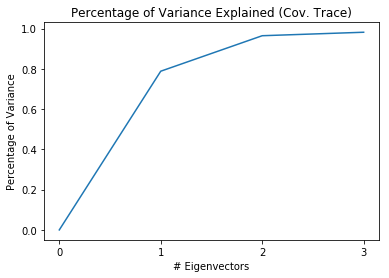

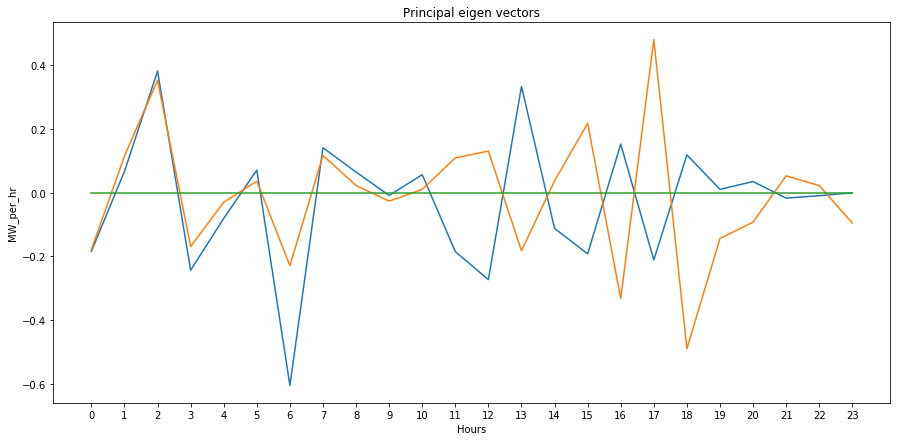

In [182]:
eigPlotFlag = True
[AEP_eigvals, AEP_eigvecs] =  AEP_Data.return_eig_data(eigPlotFlag)

+----+------------------+
|hour|   STDEV_MW_per_hr|
+----+------------------+
|   0|1927.6061741580106|
|   1|  1900.08211906197|
|   2| 1920.635776094012|
|   3| 1956.778069839942|
|   4|2006.0570749204621|
|   5|2078.0334826997114|
|   6|2207.3696759272502|
|   7|2481.5703443581842|
|   8| 2576.176193870379|
|   9|2353.2418124057976|
|  10|2154.5939466652535|
|  11| 2083.581145783219|
|  12| 2103.669285614338|
|  13|2200.6740627146014|
|  14| 2339.640454077524|
|  15| 2446.842307207588|
|  16|2513.6712899171757|
|  17| 2539.358263114022|
|  18|2520.4605465933378|
|  19|2491.9466843174287|
|  20| 2328.161858383734|
|  21|2152.6036948268384|
|  22| 2105.064244661761|
|  23|2014.3737179429716|
+----+------------------+



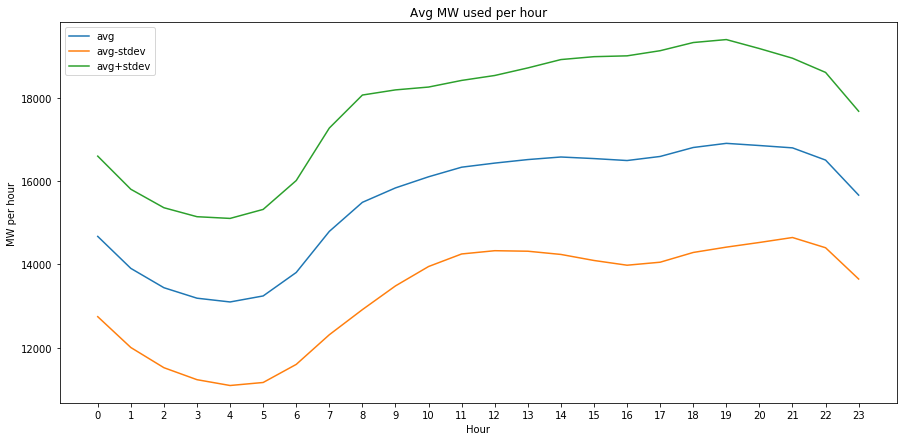

In [183]:
stdevPlotFlag = True
AEP_stdev =  AEP_Data.return_stdev_data(stdevPlotFlag)

In [184]:
[AEP_Data.rdd_MW_daily, AEP_Data.rdd_daily_coef, AEP_Data.rdd_daily_approx, AEP_Data.rdd_daily_res] = \
compute_decomposition(AEP_grouped_df, AEP_hr_avg, AEP_eigvecs)

print(AEP_Data.rdd_MW_daily.take(2))
print(AEP_Data.rdd_daily_coef.take(2))
print(AEP_Data.rdd_daily_approx.take(2))
print(AEP_Data.rdd_daily_res.take(2))

[([1, 1, 2005], array([12892, 12316, 11890, 11579, 11461, 11472, 11571, 11898, 12209,
       12396, 12997, 13455, 13617, 13665, 13446, 13340, 13159, 13449,
       14319, 14536, 14454, 14248, 13970, 13558])), ([1, 2, 2005], array([12849, 12291, 11917, 11681, 11613, 11685, 11936, 12342, 12986,
       13485, 13909, 13840, 13914, 13991, 13885, 13818, 13695, 14026,
       15073, 15269, 15265, 14916, 14521, 13805]))]
[([1, 1, 2005], array([12528.56305721,   250.62650226])), ([1, 2, 2005], array([10235.01844703,   102.47563681]))]
[([1, 1, 2005], array([12385.4850881 , 11693.28208936, 11271.82586974, 11052.98754455,
       10974.99851062, 11089.43696873, 11543.95934472, 12352.80106944,
       12937.71869313, 13291.29973115, 13550.28720765, 13714.13922006,
       13763.9360619 , 13805.47533536, 13826.62539299, 13778.97314169,
       13737.23100465, 13795.91615355, 13895.90636715, 13893.62066823,
       13983.3508522 , 14125.74237625, 13894.07162096, 13165.86089145])), ([1, 2, 2005], array([127

In [185]:
AEP_minResDate = AEP_Data.return_min_res_date()
print(AEP_minResDate)

[8, 4, 2011]


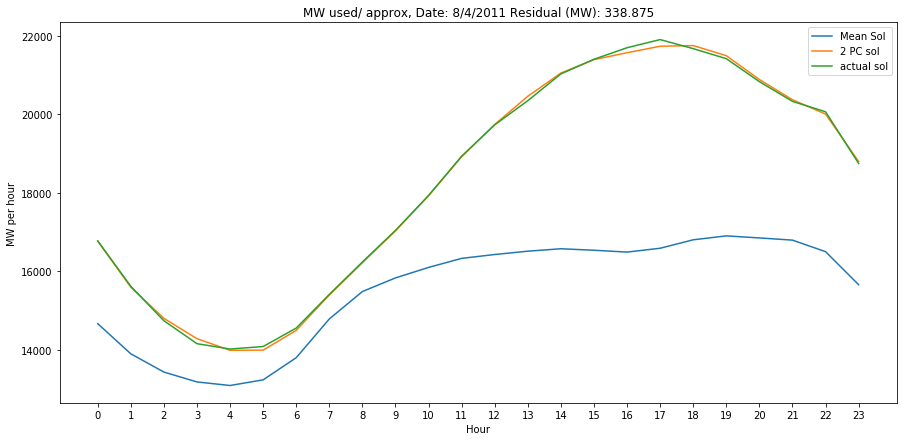

In [186]:
 AEP_Data.plot_date_decomp(AEP_minResDate)

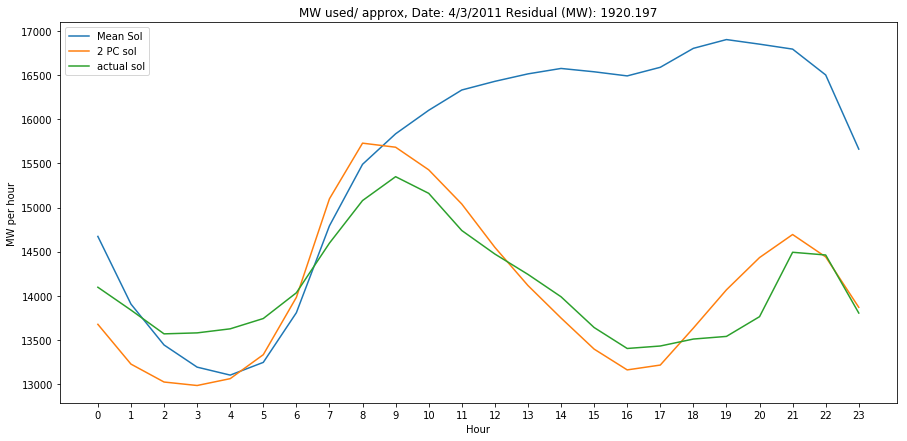

In [187]:
 AEP_Data.plot_date_decomp([4,3,2011])